In [1]:
import tensorflow as tf
# 預設情況下，tensorflow會為了避免碎片化的記憶體造成效能不佳的情況而一次性的佔用顯卡所有記憶體，
# 這部份可以透過tf.config來限制硬體資源以及指定顯卡記憶體的使用。
def select_gpu(N):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print(gpus)
    if gpus:
        try:
            for gpu in gpus:
                # If memory growth is enabled for a PhysicalDevice, 
                # the runtime initialization will not allocate all memory on the device. 
                # Memory growth cannot be configured on a PhysicalDevice with virtual devices configured.
                tf.config.experimental.set_memory_growth(gpu, True)
            # 指定使用哪顆GPU
            tf.config.experimental.set_visible_devices(gpus[N], 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)

In [2]:
select_gpu(2)
epochs = 5
model_name = 'bert-base'
sequence_length = 48
batch_size = 256

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
3 Physical GPUs, 1 Logical GPUs


In [3]:
import pandas as pd
import numpy as np
import json

In [4]:
data_path = '/home/Danny/Data-Mining/lab2/kaggle/data/'

In [5]:
json_list = list()
with open(data_path + 'tweets_DM.json' , 'r') as file:
    for line in file:
        json_list.append(json.loads(line))

In [6]:
tweet_list = list()
for json in json_list:
    tweet_id = json['_source']['tweet']['tweet_id']
    hashtags = json['_source']['tweet']['hashtags']
    hashtag = ' '.join(hashtags)
    text = json['_source']['tweet']['text']
#     text = text + ' ' + hashtag
    tweet_list.append([tweet_id, text])

In [7]:
emotion_df = pd.read_csv(data_path + 'emotion.csv')
emotion_df

,tweet_id,emotion
0,0x3140b1,sadness
1,0x368b73,disgust
2,0x296183,anticipation
3,0x2bd6e1,joy
4,0x2ee1dd,anticipation
...,...,...
1455558,0x38dba0,joy
1455559,0x300ea2,joy
1455560,0x360b99,fear
1455561,0x22eecf,joy


In [8]:
identification_df = pd.read_csv(data_path + 'data_identification.csv')
identification_df

,tweet_id,identification
0,0x28cc61,test
1,0x29e452,train
2,0x2b3819,train
3,0x2db41f,test
4,0x2a2acc,train
...,...,...
1867530,0x227e25,train
1867531,0x293813,train
1867532,0x1e1a7e,train
1867533,0x2156a5,train


In [9]:
emoji_dict = {
    "😂": "lolface",
    "😇": "smile",
    "😀": "smile",
    "🎉": "party",
    "😳": "embarrassed",
    "😔": "sadface",
    "👀": "shifty",
    "🤷": "shrugging",
    "💔": "brokenhearted",
    "👻": "ghost",
    "😍": "heart",
    "🙄": "disdain",
    "💖": "heart",
    "✌": "victory",
    "🎶": "music",
    "😱": "shock",
    "😃": "smile",
    "😒": "unsatisfied",
    "👊": "brofist",
    "😄": "smile",
    "🌞": "smile",
    "🙌": "celebration",
    "😁": "smile",
    "🤗": "hugging",
    "🤣": "rofl",
    "🌈": "gaypride",
    "😉": "winking",
    "💞": "heart",
    "🙃": "irony",
    "😜": "winking",
    "😭": "bawling",
    "🤔": "thinker",
    "😎": "cool",
    "💛": "heart",
    "💚": "heart",
    "💃": "fun",
    "💗": "heart",
    "😬": "awkward",
    "😌": "relieved",
    "😅": "whew",
    "💋": "kiss",
    "🙈": "laugh",
    "😊": "^^",
    "👌": "okay",
    "😡": "angry",
    "😘": "kiss",
    "😩": "weary",
    "🔥": "excellent",
    "💙": "heart",
    "💕": "heart",
    "👏": "clapping",
    "👍": "thumbsup",
    "💯": "perfect",
    "💜": "heart",
    "🕘" : "late",
    "😡" : "angry",
    "😒" : "dissatisfied",
    "😤" : "angry",
    "😠" : "angry",
    "😑" : "annoy",
    "😰": "anxious",
    "😯": "surprise",
    "😨": "scared",
    "😲": "astonished",
    "💪": "strong",
    "🤦": "facepalm",
    "✨": "sparkle",
    "😢": "crying",
    "💓": "heart",
    "👑": "crown",
    "🤘": "rockon",
    "🌹": "rose",
    "😋": "delicious",
    "😏": "flirting",
    "😆": "XD",
    "😫": "exhausted",
    "😦": "frowning",
    "🙏": "please",
}

In [10]:
frequent_name_dict = {
    "#realdonaldtrump": "sadness",
    "#fifthharmony": "sadness",
    "#mostrequestlive": "sadness",
    "#onairromeo": "sadness",
    "#matthardybrand": "sadness",
}

In [11]:
text_df = pd.DataFrame(tweet_list, columns=['tweet_id', 'text'])
text_df

,tweet_id,text
0,0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,0x28b412,"Confident of your obedience, I write to you, k..."
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,0x2de201,"""Trust is not the same as faith. A friend is s..."
...,...,...
1867530,0x316b80,When you buy the last 2 tickets remaining for ...
1867531,0x29d0cb,I swear all this hard work gone pay off one da...
1867532,0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...
1867533,0x24faed,"Ah, corporate life, where you can date <LH> us..."


In [12]:
# import re
# def replace_word(text):
#     text_list = text.split()
#     for i, j in enumerate(text_list):
#         if j in emoji_dict:
#             text_list[i] = emoji_dict[j]
#         if j in frequent_name_dict:
#             text_list[i] = frequent_name_dict[j]
#     text = ' '.join(text_list)
#     text = re.sub('<lh>|<|>|@|#|', '', text)
#     return text.split()

In [13]:
# text_df['token'] = text_df['text'].apply(lambda s : s.split())
# text_df

In [14]:
# %%time
# import nltk
# from nltk.tokenize import TweetTokenizer
# tweet_tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
# text_df['token'] = text_df['text'].apply(lambda s : s.lower())
# text_df['token'] = text_df['token'].apply(lambda s : tweet_tokenizer.tokenize(s))
# text_df['token'] = text_df['token'].apply(lambda s : ' '.join(s))
# text_df['token'] = text_df['token'].apply(lambda s : replace_word(s))
# text_df

In [15]:
%%time
from kashgari.tokenizers import BertTokenizer
vocab_path = '/home/Danny/pretrain_model/{}/vocab.txt'.format(model_name)
tokenizer = BertTokenizer.load_from_vocab_file(vocab_path)
text_df['token'] = text_df['text'].apply(lambda s : tokenizer.tokenize(s))
text_df

CPU times: user 6min 39s, sys: 3.46 s, total: 6min 42s
Wall time: 6min 43s


,tweet_id,text,token
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...","[people, who, post, "", add, me, on, #, snap, #..."
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...","[@, brian, ##kla, ##as, as, we, see, ,, trump,..."
2,0x28b412,"Confident of your obedience, I write to you, k...","[confident, of, your, obedience, ,, i, write, ..."
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,"[now, iss, ##a, is, stalking, tasha, 😂, ##😂, #..."
4,0x2de201,"""Trust is not the same as faith. A friend is s...","["", trust, is, not, the, same, as, faith, ., a..."
...,...,...,...
1867530,0x316b80,When you buy the last 2 tickets remaining for ...,"[when, you, buy, the, last, 2, tickets, remain..."
1867531,0x29d0cb,I swear all this hard work gone pay off one da...,"[i, swear, all, this, hard, work, gone, pay, o..."
1867532,0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...,"[@, parcel, ##2, ##go, no, card, left, when, i..."
1867533,0x24faed,"Ah, corporate life, where you can date <LH> us...","[ah, ,, corporate, life, ,, where, you, can, d..."


In [16]:
test_df = identification_df[identification_df['identification'] == 'test']
# test_df

In [17]:
train_df = text_df.merge(emotion_df, left_on='tweet_id', right_on='tweet_id')
# train_df

In [18]:
x_list = train_df['token'].to_list()
y_list = train_df['emotion'].to_list()
print(len(x_list))
print(len(y_list))

1455563
1455563


In [19]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x_list, y_list, test_size=0.2, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print(len(train_x), len(train_y))
print(len(test_x), len(test_y))
print(len(valid_x), len(valid_y))

931560 931560
291113 291113
232890 232890


In [20]:
%%time
import kashgari
from kashgari.tasks.classification import BiLSTM_Model
kashgari.config.use_cudnn_cell = True
import logging
logging.basicConfig(level='DEBUG')
from kashgari.embeddings import BertEmbedding
bert_embed = BertEmbedding('/home/Danny/pretrain_model/{}'.format(model_name))
model = BiLSTM_Model(bert_embed, 
                     sequence_length=sequence_length,
#                      sequence_length: Union[str, int] = 'auto',
                    )
history = model.fit(train_x, 
                    train_y, 
                    valid_x, 
                    valid_y,
                    epochs=epochs,
                    batch_size=batch_size,
         )

2020-12-04 14:20:35,503 [DEBUG] kashgari - ------------------------------------------------
2020-12-04 14:20:35,504 [DEBUG] kashgari - Loaded transformer model's vocab
2020-12-04 14:20:35,504 [DEBUG] kashgari - config_path       : /home/Danny/pretrain_model/bert-base/bert_config.json
2020-12-04 14:20:35,504 [DEBUG] kashgari - vocab_path      : /home/Danny/pretrain_model/bert-base/vocab.txt
2020-12-04 14:20:35,505 [DEBUG] kashgari - checkpoint_path : /home/Danny/pretrain_model/bert-base/bert_model.ckpt
2020-12-04 14:20:35,505 [DEBUG] kashgari - Top 50 words    : ['[PAD]', '[unused0]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]'

Epoch 1/5
3638/3638 [==============================] - 3151s 866ms/step - loss: 1.2581 - accuracy: 0.5432 - val_loss: 1.1303 - val_accuracy: 0.5904
Epoch 2/5
3638/3638 [==============================] - 2591s 712ms/step - loss: 1.1209 - accuracy: 0.5938 - val_loss: 1.0934 - val_accuracy: 0.6028
Epoch 3/5
3638/3638 [==============================] - 2734s 752ms/step - loss: 1.0778 - accuracy: 0.6092 - val_loss: 1.0787 - val_accuracy: 0.6088
Epoch 4/5
3638/3638 [==============================] - 2698s 741ms/step - loss: 1.0500 - accuracy: 0.6194 - val_loss: 1.0729 - val_accuracy: 0.6120
Epoch 5/5
3638/3638 [==============================] - 3437s 945ms/step - loss: 1.0286 - accuracy: 0.6267 - val_loss: 1.0712 - val_accuracy: 0.6134
CPU times: user 1h 59min 8s, sys: 9min 32s, total: 2h 8min 41s
Wall time: 4h 4min 25s


In [21]:
model_path = 'model/{}_epoch_{}'.format(model_name, epochs)
model.save(model_path)
model.evaluate(test_x, test_y)

2020-12-04 18:25:08,935 [INFO] kashgari - model saved to /home/Danny/Data-Mining/lab2/kaggle/kashgari/model/bert-base_epoch_5
2020-12-04 18:25:08,984 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 125
2020-12-04 18:25:11,916 [DEBUG] kashgari - predict input shape (2, 291113, 125) x: 
(array([[ 101, 2042, 1037, ...,    0,    0,    0],
       [ 101, 3582, 2256, ...,    0,    0,    0],
       [ 101, 4687, 2065, ...,    0,    0,    0],
       ...,
       [ 101, 1045, 2499, ...,    0,    0,    0],
       [ 101, 1026, 1048, ...,    0,    0,    0],
       [ 101, 6343, 3793, ...,    0,    0,    0]], dtype=int32), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32))
2020-12-04 19:16:38,656 [DEBUG] kashgari - predict output shape (291113, 8)
2020-12-04 19:16:38,788 [DEBUG] kashgari - p

              precision    recall  f1-score   support

       anger     0.5886    0.2604    0.3611      7946
anticipation     0.6939    0.5931    0.6395     49984
     disgust     0.5641    0.3948    0.4645     27669
        fear     0.6445    0.4822    0.5517     12846
         joy     0.6193    0.8246    0.7074    102943
     sadness     0.5040    0.6030    0.5491     38745
    surprise     0.6806    0.2377    0.3523      9816
       trust     0.5825    0.4111    0.4820     41164

    accuracy                         0.6057    291113
   macro avg     0.6097    0.4759    0.5134    291113
weighted avg     0.6087    0.6057    0.5914    291113



{'detail': {'anger': {'precision': 0.588620199146515,
   'recall': 0.26038258243141205,
   'f1-score': 0.36105051915190645,
   'support': 7946},
  'anticipation': {'precision': 0.6938976147562089,
   'recall': 0.5930697823303457,
   'f1-score': 0.6395340057170595,
   'support': 49984},
  'disgust': {'precision': 0.5641396405701301,
   'recall': 0.3948100762586288,
   'f1-score': 0.4645249080432888,
   'support': 27669},
  'fear': {'precision': 0.6445369406867846,
   'recall': 0.4821734392028647,
   'f1-score': 0.5516565728535804,
   'support': 12846},
  'joy': {'precision': 0.6193022645033267,
   'recall': 0.8246213924210486,
   'f1-score': 0.7073641230756412,
   'support': 102943},
  'sadness': {'precision': 0.5040127718329306,
   'recall': 0.6029681249193445,
   'f1-score': 0.5490675346957002,
   'support': 38745},
  'surprise': {'precision': 0.6805717619603268,
   'recall': 0.23767318663406684,
   'f1-score': 0.352310480217457,
   'support': 9816},
  'trust': {'precision': 0.5825272

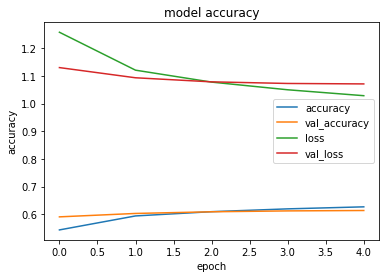

In [30]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])
plt.show()

In [23]:
# model_path = 'model/{}_epoch_{}'.format(model_name, epochs)
# model = kashgari.utils.load_model(model_path)
# model.evaluate(test_x, test_y)

In [24]:
test_df = test_df.merge(text_df, left_on='tweet_id', right_on='tweet_id')
# test_df

In [25]:
text_list = test_df['token'].tolist()
# text_list

In [26]:
predict_list = model.predict(text_list)
# predict_list

2020-12-04 19:16:49,891 [DEBUG] kashgari - predict input shape (2, 411972, 149) x: 
(array([[ 101, 1030, 5292, ...,    0,    0,    0],
       [ 101, 1030, 4419, ...,    0,    0,    0],
       [ 101, 2559, 2005, ...,    0,    0,    0],
       ...,
       [ 101, 1045, 2074, ...,    0,    0,    0],
       [ 101, 3713, 2069, ...,    0,    0,    0],
       [ 101, 2113, 2054, ...,    0,    0,    0]], dtype=int32), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32))
2020-12-04 20:40:24,685 [DEBUG] kashgari - predict output shape (411972, 8)
2020-12-04 20:40:24,872 [DEBUG] kashgari - predict output argmax: [0 3 3 ... 3 0 0]


In [27]:
test_df['predict'] = predict_list
# test_df

In [28]:
output_df = test_df[['tweet_id', 'predict']]
output_df = output_df.rename(columns={'tweet_id':'id', 'predict':'emotion'})
# output_df

In [29]:
output_path = 'output/{}-epoch-{}.csv'.format(model_name, epochs)
output_df.to_csv(output_path, index=False, header=True)